**Sensor Anomaly detections**
For the classification of target 0 for normal and 1 for Anomaly
Steps:- 
#Exploring the data: See what it deals with.

#Cleaning it up: Handling missing values and fix the Date column.

#Trying different models: I'll start with simple ones (Logistic Regression) and then try powerful ones like Random Forest and XGBoost.
#use F1-score imblance dataset

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd# data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
# For modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ana-verse-2-0-p/train.parquet
/kaggle/input/ana-verse-2-0-p/sample_submission.parquet
/kaggle/input/ana-verse-2-0-p/test.parquet


In [32]:
df = pd.read_parquet('/kaggle/input/ana-verse-2-0-p/train.parquet')

print("First 10 rows of the data:")
display(df.head())


print("\nData Info:")
df.info()

# Data Cleaning 
missing values  

In [4]:
print(df.isnull().sum())
df = df.fillna(df.mean(numeric_only=True))



Date      0
X1        0
X2        0
X3        0
X4        0
X5        0
target    0
dtype: int64


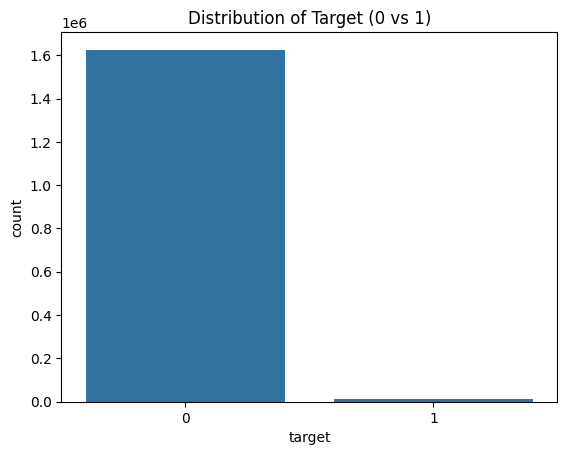

In [5]:
#here I am checking the traget distribution in the data
sns.countplot(x='target', data=df)
plt.title('Distribution of Target (0 vs 1)')
plt.show()

In [6]:
#here extracting useful numbers
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Hour'] = df['Date'].dt.hour
df['Day'] = df['Date'].dt.dayofweek

# Now I can drop the original Date column since I extracted what I needed
df = df.drop('Date', axis=1)

print("Data after processing:")
display(df.head())

Data after processing:


,X1,X2,X3,X4,X5,target,Month,Hour,Day
0,1.518921,5.463154,1.0,2.718282,2.890372,0,12,0,2
1,1.546509,5.458010,1.0,2.718282,2.833213,1,12,0,2
2,1.645427,5.456560,1.0,7.389056,2.890372,1,12,0,2
3,1.652022,5.458479,1.0,2.718282,2.890372,1,12,0,2
4,1.695538,5.466709,1.0,2.718282,2.890372,0,12,0,2


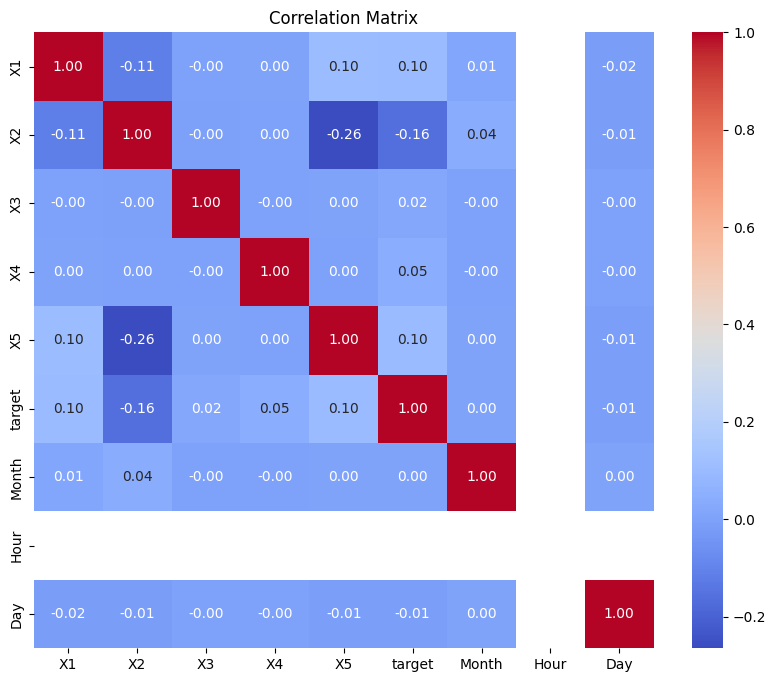

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# Looking at the bar chart I made earlier, the '1's are basically invisible
# If I train the model now, it will just predict '0' for everything and get 99% accuracy without finging '0' anomalies.

# Splitting the data


In [8]:
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Scaling the data
# Some models like KNN and Logistic Regression work better if all numbers are on the same scale (e.g., -1 to 1).
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data split and scaled successfully!")

Data split and scaled successfully!


In [14]:
# --- STEP 1: Handling that massive imbalance ---
from imblearn.over_sampling import SMOTE

print("Fixing class imbalance... this might take a second.")
smote = SMOTE(random_state=42)

# FIX: We use 'y_train' (the original data) here, NOT 'y_train_resampled'
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print("Before SMOTE, I had mostly 0s.")
print("After SMOTE, I have a balanced training set")
print(pd.Series(y_train_resampled).value_counts())

Fixing class imbalance... this might take a second.
Before SMOTE, I had mostly 0s.
After SMOTE, I have a balanced training set
target
0    1300309
1    1300309
Name: count, dtype: int64


Now applying the diffrent models
logisticRegression

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score

print("\nTraining Logistic Regression...")
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_resampled, y_train_resampled)

# Predicting on the test set (which is still the original, real data)
y_pred_log = log_reg.predict(X_test_scaled)

print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_log))


Training Logistic Regression...
Logistic Regression Results:
              precision    recall  f1-score   support

           0       1.00      0.86      0.93    325077
           1       0.05      0.88      0.10      2808

    accuracy                           0.86    327885
   macro avg       0.53      0.87      0.51    327885
weighted avg       0.99      0.86      0.92    327885



now trying it with the RandomForestClassifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

print("\nTraining Random Forest ")

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

y_pred_rf = rf_model.predict(X_test_scaled)

print("Random Forest Results:")
print(classification_report(y_test, y_pred_rf))


Training Random Forest 
Random Forest Results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    325077
           1       0.31      0.53      0.39      2808

    accuracy                           0.99    327885
   macro avg       0.65      0.76      0.69    327885
weighted avg       0.99      0.99      0.99    327885



randomForest here is taking a longer time might be good for real
but the accuracy it brings is better

In [18]:
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred_rf)

<Figure size 600x500 with 0 Axes>

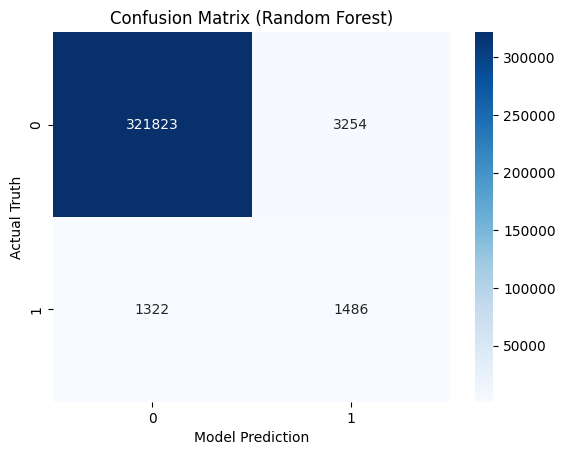

Final F1 Score: 0.3937466878643349


In [28]:
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (Random Forest)')
plt.ylabel('Actual Truth')
plt.xlabel('Model Prediction')
plt.show()

print("Final F1 Score:", f1_score(y_test.astype(int), y_pred_rf.astype(int)))

In [33]:
# --- FINAL SUBMISSION STEP ---
import os

# 1. Find and Load the Test Data
# Based on your train path, the test file should be in the same folder.
test_file_path = '/kaggle/input/ana-verse-2-0-p/test.parquet'

# Safety check: if the file name is slightly different (like .csv), find it automatically
if not os.path.exists(test_file_path):
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            if 'test' in filename.lower():
                test_file_path = os.path.join(dirname, filename)

print(f"Loading test file from: {test_file_path}")

# Load the file based on extension
if test_file_path.endswith('.parquet'):
    test_df = pd.read_parquet(test_file_path)
else:
    test_df = pd.read_csv(test_file_path)

# 2. Preprocessing (Must match training data exactly!)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df['Month'] = test_df['Date'].dt.month
test_df['Hour'] = test_df['Date'].dt.hour
test_df['Day'] = test_df['Date'].dt.dayofweek

# Save the Date column now (we need it for the final submission file)
submission_dates = test_df['Date'] 

# 3. Align Columns
# We only want the columns that the model was trained on. 
# This automatically fixes the "ID" error by ignoring extra columns.
# Note: 'X' comes from your previous training cell.
test_features = test_df[X.columns]

# 4. Scaling
# Use the SAME scaler from training. Do NOT fit again.
test_scaled = scaler.transform(test_features)

# 5. Make Predictions (Defines the missing variable!)
final_predictions = rf_model.predict(test_scaled).astype(int)

# 6. Create the Submission File
submission = pd.DataFrame({
    'Date': submission_dates,
    'target': final_predictions
})

# Save as CSV (Required for the competition)
submission.to_csv('submission.csv', index=False)

print("Success! 'submission.csv' has been saved.")
print(submission.head())

Loading test file from: /kaggle/input/ana-verse-2-0-p/test.parquet
Success! 'submission.csv' has been saved.
        Date  target
0 2020-12-16       1
1 2020-12-16       1
2 2020-12-16       0
3 2020-12-16       0
4 2020-12-16       0
